# Multinomial Naïve Bayes


Ryan Timbrook (RTIMBROO)  
DATE: 10/27/2019
Topic: Naive Bayes Text Classification


## 1. Objective
_____________________________________________________________________________________________
Use Multinomial Naïve Bayes algorithm to build models to classify the customer reviews by (1) sentiment (positive or negative) (2) authenticity (true or fake, lie detection). (6 points)

For each of the two classification tasks, use MNB to build the models, and evaluate them using 10-fold cross validation methods. You can choose your own options for tokenization, and make sure to report if you change any default setting. 

For each model (lie detection and sentiment classification), report the 20 most indicative words that the models have learned. Based on these words, do you think the models have learned the concepts (lie or sentiment) that they are expected to learn?

Also, compare the difficulty level of sentiment classification vs. lie detection. Discuss whether you believe computers can detect fake reviews by the words.



## Findings / Recommendations
place findings and recommendations here  





___________________________________________________________________________________________
## FOR RUNNING IN GOOGLE COLAB ONLY ##

In [1]:
# toggle for working with colab
isColab = False

In [ ]:
#*ONLY RUN WHEN WORKING ON COLAB*
#===================================================
# mount google drive for working in colab

#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)

# working within colab, set base working directory
#base_dir = "./gdrive/My Drive/IST707_PRJ_Realestate/buy_rent_sell/"

# validate directory mapping
#ls f'{base_dir}'

# upload custome python files
#from google.colab import files
#uploaded_files = files.upload()

# print files uploaded
#for f in uploaded_files.keys():
#  print(f'file name: {f}')

#isColab = True

______________________________________________________________________________________________
### Coding Environment Setup
Import packages

In [2]:
# import packages for analysis and modeling
# import packages for analysis and modeling
import pandas as pd #data frame operations
import numpy as np #arrays and math functions
import matplotlib.pyplot as plt #2D plotting
%matplotlib inline
import seaborn as sns #
import os
import io
from os import path
import re
from itertools import product
from scipy.stats import gaussian_kde as kde # for resampling dataset

# 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.naive_bayes import MultinomialNB

#from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, make_scorer, classification_report, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_selection import SelectKBest, chi2
#from sklearn.ensemble import VotingClassifier


import warnings
from timeit import default_timer               # performance processing time
import logging                                 # logging framework
# get loggers
warnings.filterwarnings('ignore')

In [3]:
# custome python packages
import rtimbroo_utils_hw4 as br             # custome python helper functions

In [4]:
# set global properties
notebook_file_name = 'hw4_multinominal_nb'
report_file_name = 'hw4_multinominal_nb'
app_name = 'hw4_multinominal_nb'
log_level = 10 # 10-DEBUG, 20-INFO, 30-WARNING, 40-ERROR, 50-CRITICAL

# setup working directory structure
# set global properties
if not isColab:
    dataDir = './data'
    outputDir = './output'
    configDir = './config'
    logOutDir = './logs'
    imageDir = './images'
    modelDir = './models'
    corpusDir = './corpus'
else:
    # working within colab
    dataDir = f'{base_dir}data'
    outputDir = f'{base_dir}output'
    configDir = f'{base_dir}config'
    logOutDir = f'{base_dir}logs'
    imageDir = f'{base_dir}images'
    modelDir = f'{base_dir}models'
    corpusDir = f'{base_dir}corpus'

In [5]:
# create base output directories if they don't exist
if not os.path.exists(outputDir): os.mkdir(outputDir)
if not os.path.exists(logOutDir): os.mkdir(logOutDir)
if not os.path.exists(imageDir): os.mkdir(imageDir)
if not os.path.exists(modelDir): os.mkdir(modelDir)
if not os.path.exists(corpusDir): os.mkdir(corpusDir)

In [6]:
# get a logger for troubleshooting / data exploration
logger = br.getFileLogger(logOutDir+'/',app_name,level=log_level)
np.random.seed(42) # NumPy

### Below section is for custom class definitions
##### -----------------------------------------------------------------------------------------------------------------

### Below section is for local custom functions
##### -----------------------------------------------------------------------------------------------------------------

## 2. OBTAIN the data   
________________________________________________________________________________________________
Import external datasets for evaluation

In [7]:
# datasets file names to load
deception_data = pd.read_csv(f'{dataDir}/deception_data_converted_final.tsv', delimiter='\t')
deception_data.head()
logger.info(f'deception_data shape: {deception_data.shape}')
logger.info(f'deception_data size: {deception_data.size}')
logger.info(f'deception_data len: {len(deception_data)}')
logger.info(f'deception_data.head: {deception_data.head()}')

deception_data shape: (92, 3)
deception_data size: 276
deception_data len: 92
deception_data.head:   lie sentiment                                             review
0   f         n  'Mike\'s Pizza High Point, NY Service was very...
1   f         n  'i really like this buffet restaurant in Marsh...
2   f         n  'After I went shopping with some of my friend,...
3   f         n  'Olive Oil Garden was very disappointing. I ex...
4   f         n  'The Seven Heaven restaurant was never known f...


In [ ]:
# do resampling on original dataset to enhance model training
#deception_data_resampled = deception_data.sample(n=10000, frac=None, replace=True, weights=None, random_state=42, axis=None)

### Tokenize & Create Text Corpus

In [8]:
# separate data into two distinct sets
# run each through MNB 10-fold cross validation
lie_df = deception_data.drop(columns=['sentiment'])
sentiment_df = deception_data.drop(columns=['lie'])

# testing with resampling at 1000 records from original dataset
#lie_df = deception_data_resampled.drop(columns=['sentiment'])
#sentiment_df = deception_data_resampled.drop(columns=['lie'])

In [ ]:
logger.info(f'lies dataset initial shape: {lie_df.shape}')
logger.info(f'lies dataset initial size: {lie_df.size}')
logger.info(f'sentiment dataset initial shape: {sentiment_df.shape}')
logger.info(f'sentiment dataset initial size: {sentiment_df.size}')

### 2.1 SCRUB / CLEAN
Clean and perform initial transformations tokenization and vectorization steps

Perform vectorization tasks
>

Determin **what to count** and **how to count it**<br>

Basic text preparation pipeline:

* Load the raw text.
* Split into tokens.
* Convert to lowercase.
* Remove punctuation from each token.
* Filter out remaining tokens that are not alphabetic.
* Filter out tokens that are stop words.
* Perform stemming -> [nltk reference](https://pythonprogramming.net/stemming-nltk-tutorial/)

In [9]:
# perform scrubbing and cleaning techniques
# global variables
initial_words_count = 0
cleaned_words_count = 0
feature_thres = 2
rare_thres = 5

### Tokenize 

In [10]:
# tokenize lie df - use wordpunct_tokenize
from nltk.tokenize import wordpunct_tokenize
lie_tokens_bow = []
lie_true_tokens_bow = []
lie_false_tokens_bow = []
lie_tokens_index_map = {}
lie_label_index_map = {}
for i in range(0, len(lie_df)):
    #logger.info(lie_df.iloc[i]['lie'] )
    #logger.info(lie_df.iloc[i]['review'])
    
    # tokenize
    doc_token = wordpunct_tokenize(lie_df.iloc[i]['review'])
    lie_tokens_index_map[i] = doc_token
    lie_label_index_map[i] = lie_df.iloc[i]['lie']
    #print(doc_token)
    for t in doc_token:
        # build bag of words list
        lie_tokens_bow.append(t)
        if lie_df.iloc[i]['lie'] == 't':
            lie_true_tokens_bow.append(t)
        else:
            lie_false_tokens_bow.append(t)
        
logger.info(f'Initial Lie Review All Token Count: {len(lie_tokens_bow)}')
logger.info(f'Initial Lie Review True Token Count: {len(lie_true_tokens_bow)}')
logger.info(f'Initial Lie Review False Token Count: {len(lie_false_tokens_bow)}')
logger.info(f'Initial Lie Review label index map length: {len(lie_label_index_map)}')
logger.info(f'Initial Lie Review label token map length: {len(lie_tokens_index_map)}')

Initial Lie Review All Token Count: 8152
Initial Lie Review True Token Count: 3919
Initial Lie Review False Token Count: 4233
Initial Lie Review label index map length: 92
Initial Lie Review label token map length: 92


### Perform Initial EDA on BoW for Lie Dataset

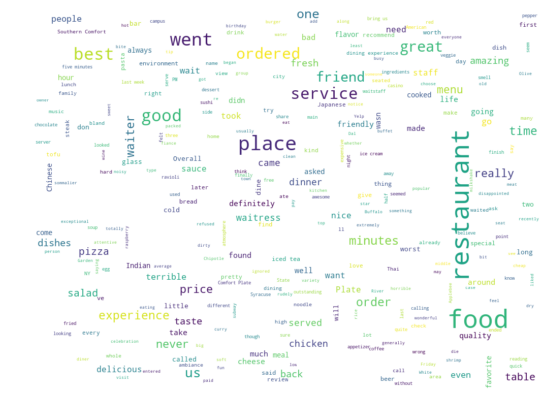

In [11]:
# initial word lie dataset - all
br.wordcloud_draw(lie_tokens_bow,color='white',max_words=300)

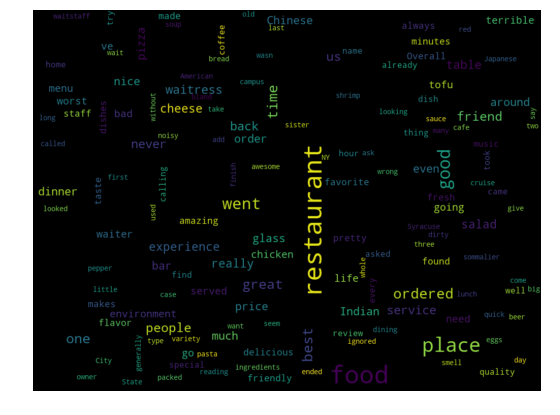

In [12]:
# initial word lie dataset - true
br.wordcloud_draw(lie_true_tokens_bow,color='black',max_words=150)

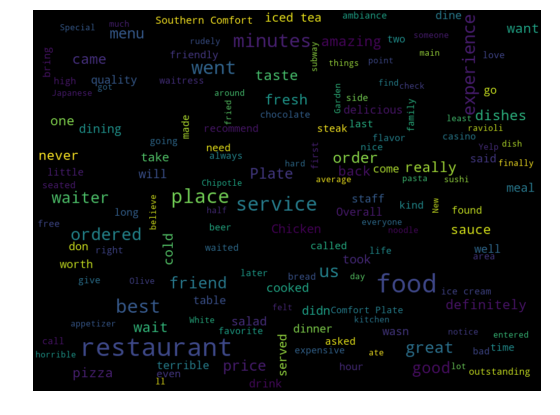

In [13]:
# initial word lie dataset - false
br.wordcloud_draw(lie_false_tokens_bow,color='black',max_words=150)

### Clean Lie dataset tokens

In [14]:
# clean tokens
kept_features = br.clean_text(logger, lie_tokens_index_map,
                     custom_stop_words=[],
                     remove_pun=True,
                     remove_non_alphabetic=True,
                     remove_stop_words=True,
                     lower_case=True,
                     stemming=False,)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rt310\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
text: 0 | feature length prior to text cleaning steps: 55
Total Tokens Prior To Cleaning: 55
text: 0 | After punctuation removal: 55
text: 0 | After non alphabetic removal: 46
text: 0 | After lower case: 46
text: 0 | After stop word removal: 28
text: 1 | feature length prior to text cleaning steps: 71
Total Tokens Prior To Cleaning: 126
text: 1 | After punctuation removal: 71
text: 1 | After non alphabetic removal: 61
text: 1 | After lower case: 61
text: 1 | After stop word removal: 34
text: 2 | feature length prior to text cleaning steps: 28
Total Tokens Prior To Cleaning: 154
text: 2 | After punctuation removal: 28
text: 2 | After non alphabetic removal: 24
text: 2 | After lower case: 24
text: 2 | After stop word removal: 11
text: 3 | feature length prior to text cleaning steps: 54
Total Tokens Prior To Cleaning: 208
text: 3 | After p

Total Tokens Prior To Cleaning: 3163
text: 32 | After punctuation removal: 91
text: 32 | After non alphabetic removal: 79
text: 32 | After lower case: 79
text: 32 | After stop word removal: 38
text: 33 | feature length prior to text cleaning steps: 77
Total Tokens Prior To Cleaning: 3240
text: 33 | After punctuation removal: 77
text: 33 | After non alphabetic removal: 62
text: 33 | After lower case: 62
text: 33 | After stop word removal: 31
text: 34 | feature length prior to text cleaning steps: 83
Total Tokens Prior To Cleaning: 3323
text: 34 | After punctuation removal: 83
text: 34 | After non alphabetic removal: 74
text: 34 | After lower case: 74
text: 34 | After stop word removal: 34
text: 35 | feature length prior to text cleaning steps: 57
Total Tokens Prior To Cleaning: 3380
text: 35 | After punctuation removal: 57
text: 35 | After non alphabetic removal: 50
text: 35 | After lower case: 50
text: 35 | After stop word removal: 23
text: 36 | feature length prior to text cleaning st

text: 64 | After lower case: 72
text: 64 | After stop word removal: 36
text: 65 | feature length prior to text cleaning steps: 165
Total Tokens Prior To Cleaning: 6261
text: 65 | After punctuation removal: 165
text: 65 | After non alphabetic removal: 146
text: 65 | After lower case: 146
text: 65 | After stop word removal: 72
text: 66 | feature length prior to text cleaning steps: 86
Total Tokens Prior To Cleaning: 6347
text: 66 | After punctuation removal: 86
text: 66 | After non alphabetic removal: 72
text: 66 | After lower case: 72
text: 66 | After stop word removal: 35
text: 67 | feature length prior to text cleaning steps: 151
Total Tokens Prior To Cleaning: 6498
text: 67 | After punctuation removal: 151
text: 67 | After non alphabetic removal: 126
text: 67 | After lower case: 126
text: 67 | After stop word removal: 61
text: 68 | feature length prior to text cleaning steps: 72
Total Tokens Prior To Cleaning: 6570
text: 68 | After punctuation removal: 72
text: 68 | After non alphabe

### Create a corpus of cleaned documents to be used in vectorization process


In [15]:
# write cleaned tokens to corpus files - file name formate <_{index}_{label}_lie_doc.txt>
cleaned_lie_true_bow = []
cleaned_lie_false_bow = []
cleaned_lie_true_bow_unique = set()
cleaned_lie_false_bow_unique = set()

cleanedLieCorpDir = f'{corpusDir}/deception/cleaned/lie'
if not os.path.exists(cleanedLieCorpDir): os.makedirs(cleanedLieCorpDir)

for index,feats in kept_features.items():
    if lie_label_index_map[index] == 't':
        for f in feats:
            cleaned_lie_true_bow.append(f)
            cleaned_lie_true_bow_unique.add(f)
    else:
        for f in feats:
            cleaned_lie_false_bow.append(f)
            cleaned_lie_false_bow_unique.add(f)
            
    with io.open(f'{cleanedLieCorpDir}/_{index}_{lie_label_index_map[index]}_lie_doc.txt','w+',encoding='utf8') as f:
        f.write(' '.join([feat for feat in feats]))

logger.info(f'cleaned lie true feats length: {len(cleaned_lie_true_bow)}')
logger.info(f'cleaned lie true unique feature count: {len(cleaned_lie_true_bow_unique)}')
logger.info(f'cleaned lie false feats length: {len(cleaned_lie_false_bow)}')
logger.info(f'cleaned lie false unique feature count: {len(cleaned_lie_false_bow_unique)}')

cleaned lie true feats length: 1650
cleaned lie true unique feature count: 833
cleaned lie false feats length: 1789
cleaned lie false unique feature count: 831


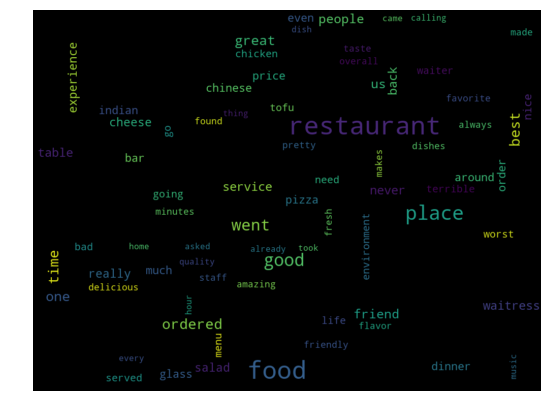

In [16]:
# cleaned word cloud lie dataset - true
br.wordcloud_draw(cleaned_lie_true_bow,color='black',max_words=75)

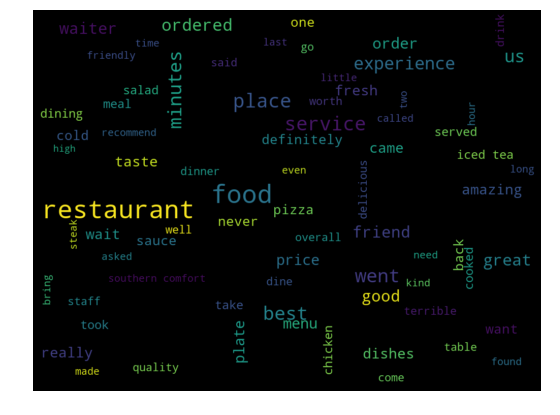

In [17]:
# cleaned word cloud lie dataset - false
br.wordcloud_draw(cleaned_lie_false_bow,color='black',max_words=75)

In [18]:
# tokenize sentiment df - use wordpunct_tokenize
from nltk.tokenize import word_tokenize
sentiment_tokens_bow = []
sentiment_neg_tokens_bow = []
sentiment_pos_tokens_bow = []
sentiment_tokens_index_map = {}
sentiment_label_index_map = {}
for i in range(0, len(sentiment_df)):
    #logger.info(lie_df.iloc[i]['sentiment'] )
    #logger.info(lie_df.iloc[i]['review'])
    
    # tokenize
    doc_token = word_tokenize(sentiment_df.iloc[i]['review'])
    sentiment_tokens_index_map[i] = doc_token
    sentiment_label_index_map[i] = sentiment_df.iloc[i]['sentiment']
    #print(doc_token)
    for t in doc_token:
        sentiment_tokens_bow.append(t)
        if sentiment_df.iloc[i]['sentiment'] == 'p':
            sentiment_pos_tokens_bow.append(t)
        else:
            sentiment_neg_tokens_bow.append(t)
        
logger.info(f'Initial Sentiment Review Token Count: {len(sentiment_tokens_bow)}')
logger.info(f'Initial Sentiment Review Pos Token Count: {len(sentiment_pos_tokens_bow)}')
logger.info(f'Initial Sentiment Review Neg Token Count: {len(sentiment_neg_tokens_bow)}')

Initial Sentiment Review Token Count: 8079
Initial Sentiment Review Pos Token Count: 3352
Initial Sentiment Review Neg Token Count: 4727


### Perform Initial EDA on BoW for Sentiment Dataset

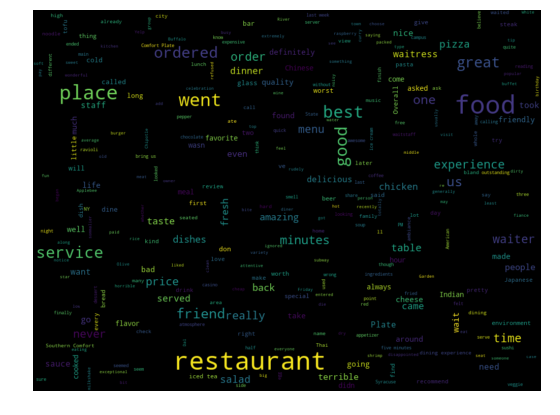

In [19]:
# initial word lie dataset - all
br.wordcloud_draw(sentiment_tokens_bow,color='black',max_words=300)

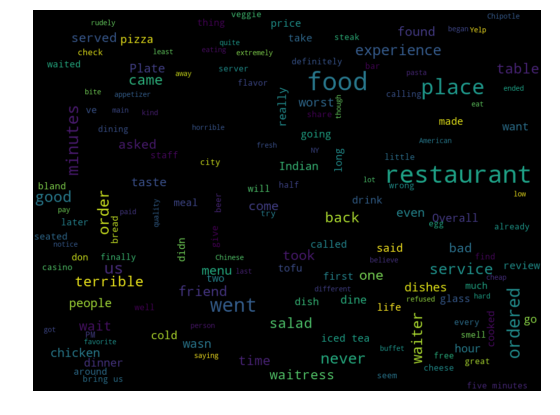

In [20]:
# initial word lie dataset - true
br.wordcloud_draw(sentiment_neg_tokens_bow,color='black',max_words=150)

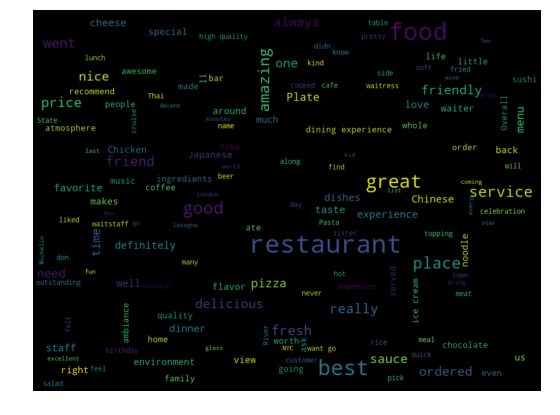

In [21]:
# initial word lie dataset - false
br.wordcloud_draw(sentiment_pos_tokens_bow,color='black',max_words=150)

### Clean Sentiment documents

In [22]:
# clean tokens
sent_kept_features = br.clean_text(logger, sentiment_tokens_index_map,
                     custom_stop_words=[],
                     remove_pun=True,
                     remove_non_alphabetic=True,
                     remove_stop_words=True,
                     lower_case=True,
                     stemming=False,)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rt310\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
text: 0 | feature length prior to text cleaning steps: 52
Total Tokens Prior To Cleaning: 52
text: 0 | After punctuation removal: 52
text: 0 | After non alphabetic removal: 45
text: 0 | After lower case: 45
text: 0 | After stop word removal: 27
text: 1 | feature length prior to text cleaning steps: 72
Total Tokens Prior To Cleaning: 124
text: 1 | After punctuation removal: 72
text: 1 | After non alphabetic removal: 61
text: 1 | After lower case: 61
text: 1 | After stop word removal: 34
text: 2 | feature length prior to text cleaning steps: 28
Total Tokens Prior To Cleaning: 152
text: 2 | After punctuation removal: 28
text: 2 | After non alphabetic removal: 24
text: 2 | After lower case: 24
text: 2 | After stop word removal: 11
text: 3 | feature length prior to text cleaning steps: 53
Total Tokens Prior To Cleaning: 205
text: 3 | After p

Total Tokens Prior To Cleaning: 3113
text: 32 | After punctuation removal: 90
text: 32 | After non alphabetic removal: 79
text: 32 | After lower case: 79
text: 32 | After stop word removal: 38
text: 33 | feature length prior to text cleaning steps: 73
Total Tokens Prior To Cleaning: 3186
text: 33 | After punctuation removal: 73
text: 33 | After non alphabetic removal: 60
text: 33 | After lower case: 60
text: 33 | After stop word removal: 31
text: 34 | feature length prior to text cleaning steps: 84
Total Tokens Prior To Cleaning: 3270
text: 34 | After punctuation removal: 84
text: 34 | After non alphabetic removal: 74
text: 34 | After lower case: 74
text: 34 | After stop word removal: 34
text: 35 | feature length prior to text cleaning steps: 58
Total Tokens Prior To Cleaning: 3328
text: 35 | After punctuation removal: 58
text: 35 | After non alphabetic removal: 50
text: 35 | After lower case: 50
text: 35 | After stop word removal: 23
text: 36 | feature length prior to text cleaning st

text: 64 | After lower case: 72
text: 64 | After stop word removal: 36
text: 65 | feature length prior to text cleaning steps: 158
Total Tokens Prior To Cleaning: 6147
text: 65 | After punctuation removal: 158
text: 65 | After non alphabetic removal: 144
text: 65 | After lower case: 144
text: 65 | After stop word removal: 74
text: 66 | feature length prior to text cleaning steps: 84
Total Tokens Prior To Cleaning: 6231
text: 66 | After punctuation removal: 84
text: 66 | After non alphabetic removal: 71
text: 66 | After lower case: 71
text: 66 | After stop word removal: 36
text: 67 | feature length prior to text cleaning steps: 143
Total Tokens Prior To Cleaning: 6374
text: 67 | After punctuation removal: 143
text: 67 | After non alphabetic removal: 123
text: 67 | After lower case: 123
text: 67 | After stop word removal: 62
text: 68 | feature length prior to text cleaning steps: 73
Total Tokens Prior To Cleaning: 6447
text: 68 | After punctuation removal: 73
text: 68 | After non alphabe

### Create a corpus of cleaned documents to be used in vectorization process

In [23]:
# write cleaned tokens to corpus files - file name formate <_{index}_{label}_lie_doc.txt>
cleaned_sent_pos_bow = []
cleaned_sent_neg_bow = []
cleaned_sent_pos_bow_unique = set()
cleaned_sent_neg_bow_unique = set()

cleanedSentimentCorpDir = f'{corpusDir}/deception/cleaned/sentiment'
if not os.path.exists(cleanedSentimentCorpDir): os.makedirs(cleanedSentimentCorpDir)

for index,feats in sent_kept_features.items():
    with io.open(f'{cleanedSentimentCorpDir}/_{index}_{sentiment_label_index_map[index]}_sentiment_doc.txt','w+',encoding='utf8') as f:
        f.write(' '.join([feat for feat in feats]))

## 3. MODEL
_________________________________________________________________________________________________
Create models

### 3.1 Model Analysis
perform model creation and validation techniques

In [24]:
# get cleaned corpus from file system
# get cleaned team text files from path - lies dataset
path = f'{corpusDir}/deception/cleaned/lie'
_files_lies = []
_filenames_lies = {}

for dirpath, dirs, files in os.walk(path):
    #print(dirpath)
    #print(dirs)
    #print(files)
    for i,f in enumerate(files):
        _files_lies.append(dirpath+'/'+f)
        file_tokens = f.split('_')
        doc_index =  file_tokens[1]
        #print(doc_index)
        #break
        
        _filenames_lies[int(doc_index)] = f

logger.info(f'corpus lies _files_lies collected: {len(_files_lies)}')
logger.info(f'corpus lies _filenames_lies collected: {len(_filenames_lies)}')

corpus lies _files_lies collected: 92
corpus lies _filenames_lies collected: 92


In [ ]:
#_filenames_lies

In [25]:
# get cleaned corpus from file system
# get cleaned team text files from path - lies dataset
path = f'{corpusDir}/deception/cleaned/sentiment'
_files_sentiment = []
_filenames_sentiment = {}

for dirpath, dirs, files in os.walk(path):
    #print(dirpath)
    #print(dirs)
    #print(files)
    for i,f in enumerate(files):
        _files_sentiment.append(dirpath+'/'+f)
        file_tokens = f.split('_')
        doc_index =  file_tokens[1]
        _filenames_sentiment[int(doc_index)] = f

logger.info(f'corpus sentiment _files_sentiment collected: {len(_files_sentiment)}')
logger.info(f'corpus sentiment _filenames_sentiment collected: {len(_filenames_sentiment)}')

corpus sentiment _files_sentiment collected: 92
corpus sentiment _filenames_sentiment collected: 92


In [ ]:
#_filenames_sentiment

### 3.2 Model Exploration

In [26]:
# create vectors for MNB modeling
# initialize a CountVectorizer object:
# Initialize a unigram vector object
count_vec_unigram = br.inst_vectorizer('unigram','count')
tfidf_vec_unigram = br.inst_vectorizer('unigram','tfidf')
#-------------------------------------------------------#
# Initialize a bigram vector object
count_vec_bigram = br.inst_vectorizer('bigram','count')
tfidf_vec_bigram = br.inst_vectorizer('bigram','tfidf')
#-------------------------------------------------------#
# Initialize a trigram vector object
count_vec_trigram = br.inst_vectorizer('trigram','count')
tfidf_vec_trigram = br.inst_vectorizer('trigram','tfidf')
#-------------------------------------------------------#

### Train Vectorizers vectors

In [27]:
# train vector - returns tuple as (fit, transform, features, voc_df)

#----Train Lie Vectorizers-----------#
##----CountVectorizers--------------##
lie_cnt_vec_unigram = br.train_vector(logger, count_vec_unigram, _files_lies)
lie_cnt_vec_unigram_id_map = br.compress_text_representation(logger, lie_cnt_vec_unigram[0])

lie_cnt_vec_bigram = br.train_vector(logger, count_vec_bigram, _files_lies)
lie_cnt_vec_bigram_id_map = br.compress_text_representation(logger, lie_cnt_vec_bigram[0])
                                     
lie_cnt_vec_trigram = br.train_vector(logger, count_vec_trigram, _files_lies)
lie_cnt_vec_trigram_id_map = br.compress_text_representation(logger, lie_cnt_vec_trigram[0])                                     
##----TfidfVectorizers--------------##
lie_tfidf_vec_unigram = br.train_vector(logger, tfidf_vec_unigram, _files_lies)
lie_tfidf_vec_unigram_id_map = br.compress_text_representation(logger, lie_tfidf_vec_unigram[0])
                                     
lie_tfidf_vec_bigram = br.train_vector(logger, tfidf_vec_bigram, _files_lies)
lie_tfidf_vec_bigram_id_map = br.compress_text_representation(logger, lie_tfidf_vec_bigram[0])
                                     
lie_tfidf_vec_trigram = br.train_vector(logger, tfidf_vec_trigram, _files_lies)
lie_tfidf_vec_trigram_id_map = br.compress_text_representation(logger, lie_tfidf_vec_trigram[0])

#----Train Sentiment Vectorizers-----#
##----CountVectorizers--------------##
sent_cnt_vec_unigram = br.train_vector(logger, count_vec_unigram, _files_sentiment)
sent_cnt_vec_unigram_id_map = br.compress_text_representation(logger, sent_cnt_vec_unigram[0])
                                     
sent_cnt_vec_bigram = br.train_vector(logger, count_vec_bigram, _files_sentiment)
sent_cnt_vec_bigram_id_map = br.compress_text_representation(logger, sent_cnt_vec_bigram[0])
                                    
sent_cnt_vec_trigram = br.train_vector(logger, count_vec_trigram, _files_sentiment)
sent_cnt_vec_trigram_id_map = br.compress_text_representation(logger, sent_cnt_vec_trigram[0])                                     
##----TfidfVectorizers--------------##
sent_tfidf_vec_unigram = br.train_vector(logger, tfidf_vec_unigram, _files_sentiment)
sent_tfidf_vec_unigram_id_map = br.compress_text_representation(logger, sent_tfidf_vec_unigram[0])
                                     
sent_tfidf_vec_bigram = br.train_vector(logger, tfidf_vec_bigram, _files_sentiment)
sent_tfidf_vec_bigram_id_map = br.compress_text_representation(logger, sent_tfidf_vec_bigram[0])
                                     
sent_tfidf_vec_trigram = br.train_vector(logger, tfidf_vec_trigram, _files_sentiment)
sent_tfidf_vec_trigram_id_map = br.compress_text_representation(logger, sent_tfidf_vec_trigram[0])

Vectorizer transformed shape: (92, 1225)
Vectorizer transformed size: 2606
Vectorizer transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer vocabulary size: 1225
Vector Head:
          feature  feature_index
762       yuenan           1224
449        wreck           1214
565    wondering           1204
1079    whelming           1194
411       watery           1184
186         wake           1174
1197      visits           1164
774   vegetarian           1154
488         used           1144
1221  understand           1134
714        twice           1124
752        trees           1114
169         took           1104
661          tip           1094
715       thanks           1084
1139       tasty           1074
906        taken           1064
263     supposed           1054
244           su           1044
1183       stood           1034
Vectorizer transformed shape: (92, 3912)
Vectorizer transformed size: 5482
Vectorizer transformed type: <class 'scipy.sparse.csr.csr_matrix

Vectorizer transformed shape: (92, 1234)
Vectorizer transformed size: 2630
Vectorizer transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer vocabulary size: 1234
Vector Head:
           feature  feature_index
769        yuenan           1233
809           wqr           1223
550          wont           1213
368         white           1203
230           way           1193
93           walk           1183
160          wait           1173
371        veggie           1163
322       usually           1153
748   undoubtedly           1143
758          twin           1133
351   tripadvisor           1123
884      toppings           1113
714       tipping           1103
393         thing           1093
1232        teach           1083
860        talked           1073
342     surprised           1063
333        subway           1053
740        stores           1043
Vectorizer transformed shape: (92, 3953)
Vectorizer transformed size: 5531
Vectorizer transformed type: <class 'scipy.

In [ ]:
lie_cnt_vec_unigram_id_map

In [28]:
# save each vectorizers feature vectors to file
#-------------------LIE VECTORS --------------------------------------------#
print(0)
save_as = f'{outputDir}/lie_cnt_feature_vector_unigram.txt' # path and name of saved feature vector
br.output_feature_vector(logger,save_as,lie_cnt_vec_unigram[2],lie_cnt_vec_unigram[1],_filenames_lies,lie_cnt_vec_unigram_id_map[0])
print(1)
save_as = f'{outputDir}/lie_cnt_feature_vector_bigram.txt' # path and name of saved feature vector
br.output_feature_vector(logger,save_as,lie_cnt_vec_bigram[2],lie_cnt_vec_bigram[1],_filenames_lies,lie_cnt_vec_bigram_id_map[0])
print(2)
save_as = f'{outputDir}/lie_cnt_feature_vector_trigram.txt' # path and name of saved feature vector
br.output_feature_vector(logger,save_as,lie_cnt_vec_trigram[2],lie_cnt_vec_trigram[1],_filenames_lies,lie_cnt_vec_trigram_id_map[0])
print(3)
save_as = f'{outputDir}/lie_tfidf_feature_vector_unigram.txt' # path and name of saved feature vector
br.output_feature_vector(logger,save_as,lie_tfidf_vec_unigram[2],lie_tfidf_vec_unigram[1],_filenames_lies,lie_tfidf_vec_unigram_id_map[0])
print(4)
save_as = f'{outputDir}/lie_tfidf_feature_vector_bigram.txt' # path and name of saved feature vector
br.output_feature_vector(logger,save_as,lie_tfidf_vec_bigram[2],lie_tfidf_vec_bigram[1],_filenames_lies,lie_tfidf_vec_bigram_id_map[0])
print(5)
save_as = f'{outputDir}/lie_tfidf_feature_vector_trigram.txt' # path and name of saved feature vector
br.output_feature_vector(logger,save_as,lie_tfidf_vec_trigram[2],lie_tfidf_vec_trigram[1],_filenames_lies,lie_tfidf_vec_trigram_id_map[0])

#----------SENTIMENT VECTORS-------------------------------------------------#
print(6)
save_as = f'{outputDir}/sent_cnt_feature_vector_unigram.txt' # path and name of saved feature vector
br.output_feature_vector(logger,save_as,sent_cnt_vec_unigram[2],sent_cnt_vec_unigram[1],_filenames_sentiment,sent_cnt_vec_unigram_id_map[0])
print(7)
save_as = f'{outputDir}/sent_cnt_feature_vector_bigram.txt' # path and name of saved feature vector
br.output_feature_vector(logger,save_as,sent_cnt_vec_bigram[2],sent_cnt_vec_bigram[1],_filenames_sentiment,sent_cnt_vec_bigram_id_map[0])
print(8)
save_as = f'{outputDir}/sent_cnt_feature_vector_trigram.txt' # path and name of saved feature vector
br.output_feature_vector(logger,save_as,sent_cnt_vec_trigram[2],sent_cnt_vec_trigram[1],_filenames_sentiment,sent_cnt_vec_trigram_id_map[0])
print(9)
save_as = f'{outputDir}/sent_tfidf_feature_vector_unigram.txt' # path and name of saved feature vector
br.output_feature_vector(logger,save_as,sent_tfidf_vec_unigram[2],sent_tfidf_vec_unigram[1],_filenames_sentiment,sent_tfidf_vec_unigram_id_map[0])
print(10)
save_as = f'{outputDir}/sent_tfidf_feature_vector_bigram.txt' # path and name of saved feature vector
br.output_feature_vector(logger,save_as,sent_tfidf_vec_bigram[2],sent_tfidf_vec_bigram[1],_filenames_sentiment,sent_tfidf_vec_bigram_id_map[0])
print(11)
save_as = f'{outputDir}/sent_tfidf_feature_vector_trigram.txt' # path and name of saved feature vector
br.output_feature_vector(logger,save_as,sent_tfidf_vec_trigram[2],sent_tfidf_vec_trigram[1],_filenames_sentiment,sent_tfidf_vec_trigram_id_map[0])


0
1
2
3
4
5
6
7
8
9
10
11


0

### Setup vectorized datasets for train/test splits

In [29]:
# one hot encoding for dataset labels

lie_labels = [l for l in lie_label_index_map.values()] 
sent_labels = [l for l in sentiment_label_index_map.values()]
lbe = LabelEncoder()
y_lie = lbe.fit_transform(lie_labels)
y_sent = lbe.fit_transform(sent_labels)
logger.info(f'y_lie encoded length: {len(y_lie)}')
logger.info(f'y_sent encoded length: {len(y_sent)}')

y_lie encoded length: 92
y_sent encoded length: 92


In [30]:
X_train_lie_dfs = {}
#----------------------LIE------------------------------#
# unigrams
X_lie_cnt_unigram = pd.DataFrame(lie_cnt_vec_unigram[1].toarray(),columns=lie_cnt_vec_unigram[2])
X_train_lie_dfs['lie_cnt_unigram'] = X_lie_cnt_unigram
logger.info(f'X_lie_cnt_unigram length: {len(X_lie_cnt_unigram)}')

X_lie_tfidf_unigram = pd.DataFrame(lie_tfidf_vec_unigram[1].toarray(),columns=lie_tfidf_vec_unigram[2])
X_train_lie_dfs['lie_tfidf_unigram'] = X_lie_tfidf_unigram

# bigrams
X_lie_cnt_bigram = pd.DataFrame(lie_cnt_vec_bigram[1].toarray(),columns=lie_cnt_vec_bigram[2])
X_train_lie_dfs['lie_cnt_bigram'] = X_lie_cnt_bigram

X_lie_tfidf_bigram = pd.DataFrame(lie_tfidf_vec_bigram[1].toarray(),columns=lie_tfidf_vec_bigram[2])
X_train_lie_dfs['lie_tfidf_bigram'] = X_lie_tfidf_bigram

# trigrams
X_lie_cnt_trigram = pd.DataFrame(lie_cnt_vec_trigram[1].toarray(),columns=lie_cnt_vec_trigram[2])
X_train_lie_dfs['lie_cnt_trigram'] = X_lie_cnt_trigram

X_lie_tfidf_trigram = pd.DataFrame(lie_tfidf_vec_trigram[1].toarray(),columns=lie_tfidf_vec_trigram[2])
X_train_lie_dfs['lie_tfidf_trigram'] = X_lie_tfidf_trigram

#----------------------SENTIMENT------------------------#
# unigrams
X_train_sent_dfs = {}
X_sent_cnt_unigram = pd.DataFrame(sent_cnt_vec_unigram[1].toarray(),columns=sent_cnt_vec_unigram[2])
X_train_sent_dfs['sent_cnt_unigram'] = X_sent_cnt_unigram

X_sent_tfidf_unigram = pd.DataFrame(sent_tfidf_vec_unigram[1].toarray(),columns=sent_tfidf_vec_unigram[2])
X_train_sent_dfs['sent_tfidf_unigram'] = X_sent_tfidf_unigram

# bigrams
X_sent_cnt_bigram = pd.DataFrame(sent_cnt_vec_bigram[1].toarray(),columns=sent_cnt_vec_bigram[2])
X_train_sent_dfs['sent_cnt_bigram'] = X_sent_cnt_bigram

X_sent_tfidf_bigram = pd.DataFrame(sent_tfidf_vec_bigram[1].toarray(),columns=sent_tfidf_vec_bigram[2])
X_train_sent_dfs['sent_tfidf_bigram'] = X_sent_tfidf_bigram

# trigrams
X_sent_cnt_trigram = pd.DataFrame(sent_cnt_vec_trigram[1].toarray(),columns=sent_cnt_vec_trigram[2])
X_train_sent_dfs['sent_cnt_trigram'] = X_sent_cnt_trigram

X_sent_tfidf_trigram = pd.DataFrame(sent_tfidf_vec_trigram[1].toarray(),columns=sent_tfidf_vec_trigram[2])
X_train_sent_dfs['sent_tfidf_trigram'] = X_sent_tfidf_trigram


logger.info(f'X_train_lie_dfs length: {len(X_train_lie_dfs)}')
logger.info(f'X_train_sent_dfs length: {len(X_train_sent_dfs)}')

X_lie_cnt_unigram length: 92
X_train_lie_dfs length: 6
X_train_sent_dfs length: 6


In [34]:
X_sent_cnt_trigram.head()

,abc,abc restaurant,abc restaurant days,abruptly,abruptly want,abruptly want place,absolutely,absolutely world,absolutely world ice,acceptable,...,yesterday went casinorestaurant,york,york city,york city best,york city menu,york known,york known exotic,yuenan,yuenan restaurant,yuenan restaurant noodle
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.3 Model Build

### 2.2.2 Create Model with CV
Python Package: [SciKit-Learn model_selection cross_validate](https://scikit-learn.org/stable/modules/cross_validation.html)   
See also [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) for more details.  

A risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.  

Cross-Validate at 10 folds...

### Create Training and Test Splits
Using the full data set, create training and test splits   

In [31]:
def build_test_validate_models(logger,m_name,X,y,reportPath,outputDir,feature_vec_file,cv=10,test_size=0.2):
    model_names = []
    # create training test splits
    # hold out part of the available data as a test set X_test, y_test
    with open(f'{reportPath}', 'a') as f:
        logger.info(f'Model Name:             {m_name}')
        f.write('{0:-<40} {1}\n'.format('Model Name:',m_name))
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        # plot training validating label split
        br.plot_train_test_label_split(y_train, y_test, 2)
        
        #-------------------Build Cross Validate Model----------------------------#
        cv = 10
        scoring = ['precision_macro', 'recall_macro']
        mnb = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
        t = 0.0
        with br.elapsed_timer() as elapsed:
            mnb_scores = cross_validate(mnb, X_train, y_train, scoring=scoring, cv=cv, 
                                        return_train_score=True, return_estimator=True) 
            t = elapsed()
            logger.info(f' Build Time: [{t}]')
            f.write('{0:-<40} {1}\n'.format('Build Time: ',[t]))
        
        #--------------------------------------------------------------------------#
        
        logger.debug(f'Fit Time:               {mnb_scores["fit_time"]}')
        logger.debug(f'Score Time:             {mnb_scores["score_time"]}')
        logger.debug(f'Test Recall Scores:     {mnb_scores["test_recall_macro"]}')
        logger.debug(f'Test Precision Scores:  {mnb_scores["test_precision_macro"]}')
        logger.debug(f'Train Recall Scores:    {mnb_scores["train_recall_macro"]}')
        logger.debug(f'Train Precision Scores: {mnb_scores["train_precision_macro"]}')
                    
        f.write('{0:-<40} {1}\n'.format('Fit Time:',[mnb_scores["fit_time"]]))
        f.write('{0:-<40} {1}\n'.format('Score Time:',[mnb_scores["score_time"]]))
        f.write('{0:-<40} {1}\n'.format('Test Recall Scores:',[mnb_scores["test_recall_macro"]]))
        f.write('{0:-<40} {1}\n'.format('Test Precision Scores:',[mnb_scores["test_precision_macro"]]))
        f.write('{0:-<40} {1}\n'.format('Train Recall Scores:',[mnb_scores["train_recall_macro"]]))
        f.write('{0:-<40} {1}\n'.format('Train Precision Scores:',[mnb_scores["train_precision_macro"]]))
        
        #---------------------BEST FIT ESTIMATOR-----------------------------------#
        # best fit estimator
        bestFit = mnb_scores["test_precision_macro"].argmax()
        mnb_scores_est = mnb_scores['estimator'][bestFit]

        # predict on unseen data
        t = 0.0
        with br.elapsed_timer() as elapsed:
            mnb_pred = mnb_scores_est.predict(X_test)
            t = elapsed()
            logger.info(f'Mulitnomial Naive Bayes with CV Predict Time: [{t}]')
            f.write('\n{0:-<40} {1}\n'.format('Predict Time:',[t]))
        #---------------------------------------------------------------------------#
        
        #---------------------EVALUATE MODEL----------------------------------------#
        misLabeled = (y_test != mnb_pred).sum()/X_test.shape[0]
        nbCVAccuractelyLabeled = 1-misLabeled

        logger.debug(f'Total Number of points: [{X_test.shape[0]}]  Mislabeled Points: [{(y_test != mnb_pred).sum()}]')
        logger.debug(f'Percent Mislabeled: [{((y_test != mnb_pred).sum()/X_test.shape[0])}]')
        logger.debug(f'Percent Accurately Labeled: [{nbCVAccuractelyLabeled}]')
        f.write('\n')
        f.write('{0:-<40} {1} | {2}\n'.format('Total Number of points | Misslabeled Points:',[X_test.shape[0]],[(y_test != mnb_pred).sum()]))
        f.write('{0:-<40} {1}\n'.format('Percent Mislabeled:',[((y_test != mnb_pred).sum()/X_test.shape[0])]))
        f.write('{0:-<40} {1}\n'.format('Percent Accurately Labeled:',[nbCVAccuractelyLabeled]))

        # confusion matrix evaluation
        cm = confusion_matrix(y_test,mnb_pred, labels=[0,1])
        logger.debug(f'{cm}')
        f.write(f'Confusion Matrix: \n{cm}\n')
        f.write(f'\n')             
        
        br.plot_confusion_matrix(cm,classes=[0,1])
        #---------------------------------------------------------------------------#
                    
        #--------------------Model Results-------------------------------------------#
        result_df = X_test
        result_df['True_Label'] = y_test
        result_df['Predicted_Label'] = mnb_pred
        
        # create a merged dataframe of the true, predicted labels along with the word frequency vector for observation
        path = f'{outputDir}/{feature_vec_file}'
        save_as = f'{outputDir}/{m_name}_predicted_results.csv'

        predicted_results_wf = br.evaluate_predicted_result(logger, f'{path}',result_df)
        logger.info(predicted_results_wf.head(10))

        predicted_results_wf.to_csv(save_as,index=False)
        

Model Name:             lie_cnt_unigram


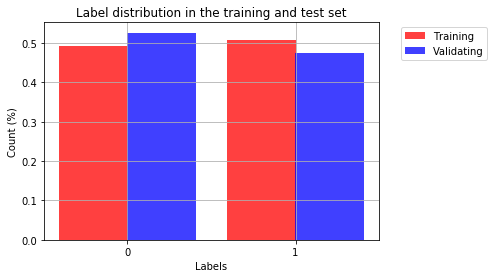

 Build Time: [0.17730290000054083]
Mulitnomial Naive Bayes with CV Predict Time: [0.0017864000001281966]


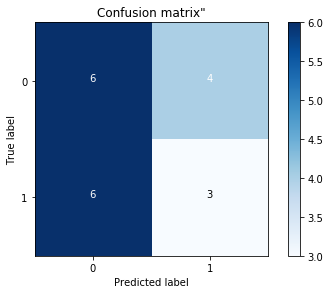

   id                                     word_frequency
0   0  [consider:1, dining:1, dishes:1, good:1, high:...
1   4  [abruptly:1, aforementioned:1, bland:1, brewed...
2  10  [ambiance:1, audience:1, bread:1, budget:1, ca...
3  12  [asked:1, assistant:1, best:1, bought:1, butch...
4  18  [benedict:1, cheese:1, cool:1, dead:1, diner:1...
   id  True_Label  Predicted_Label  \
0  40           1                0   
1  22           0                0   
2  55           0                0   
3  72           1                0   
4   0           0                0   

                                      word_frequency  
0  [awesome:1, bar:1, bring:1, cicero:1, desserts...  
1  [dinner:1, dishes:1, dodo:1, friend:1, restaur...  
2  [acknowledge:1, appetizer:1, applied:2, asked:...  
3  [ad:1, amazing:1, browse:1, chairs:1, comfy:1,...  
4  [consider:1, dining:1, dishes:1, good:1, high:...  
   id  True_Label  Predicted_Label  \
0  40           1                0   
1  22           0      

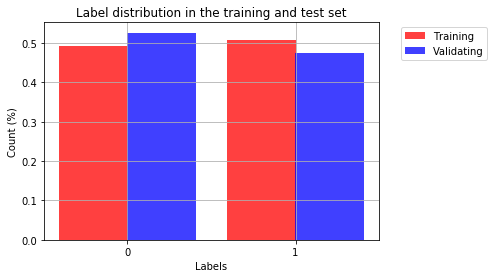

 Build Time: [0.40670009999939793]
Mulitnomial Naive Bayes with CV Predict Time: [0.004308300000047893]


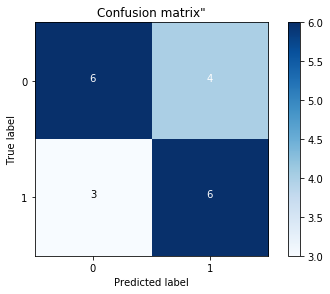

   id                                     word_frequency
0  15  [bar:1, bar_decor:1, bathroom:1, bathroom_dirt...
1  16  [come:1, come_place:1, extremely:1, extremely_...
2  17  [dishes:1, dishes_ordered:1, finish:1, friday:...
3  18  [benedict:1, benedict_nacho:1, cheese:1, chees...
4  23  [appetizer:1, appetizer_wrong:1, applebees:1, ...
   id  True_Label  Predicted_Label  \
0  79           1                1   
1  57           0                1   
2  18           0                1   
3  15           0                1   
4  67           0                0   

                                      word_frequency  
0  [ate:1, ate_talked:1, busy:1, busy_life:1, cal...  
1  [ask:1, ask_want:1, bring:1, bring_ore:1, danc...  
2  [benedict:1, benedict_nacho:1, cheese:1, chees...  
3  [bar:1, bar_decor:1, bathroom:1, bathroom_dirt...  
4  [chicken:1, chicken_wings:1, friendly:1, frien...  
   id  True_Label  Predicted_Label  \
0  79           1                1   
1  57           0      

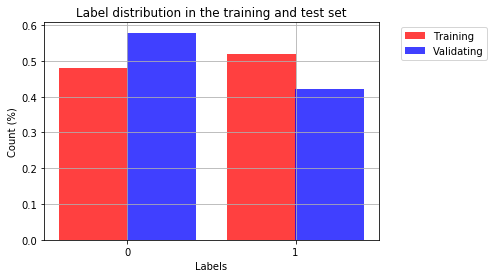

 Build Time: [0.35490219999974215]
Mulitnomial Naive Bayes with CV Predict Time: [0.0026583999997455976]


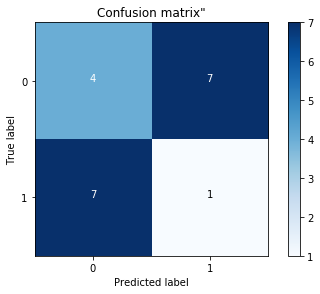

   id                                     word_frequency
0   3  [angry:1, angry_rudely:1, angry_rudely_walk:1,...
1   7  [acceptable:1, acceptable_friends:1, acceptabl...
2   9  [average:1, average_wait:1, average_wait_minut...
3  12  [asked:1, asked_shop:1, asked_shop_assistant:1...
4  13  [additional:1, additional_hour:1, additional_h...
   id  True_Label  Predicted_Label  \
0  33           1                0   
1  36           1                0   
2  20           0                1   
3  48           0                0   
4  50           0                1   

                                      word_frequency  
0  [cold:1, cold_got:1, cold_got_waitor:1, disapp...  
1  [background:1, background_food:1, background_f...  
2  [actually:1, actually_came:1, actually_came_sa...  
3  [absolutely:1, absolutely_world:1, absolutely_...  
4  [ago:1, ago_went:1, ago_went_rooftop:1, best:1...  
   id  True_Label  Predicted_Label  \
0  33           1                0   
1  36           1      

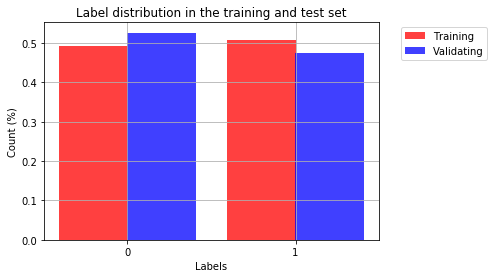

 Build Time: [0.5036607000001823]
Mulitnomial Naive Bayes with CV Predict Time: [0.003743399999621033]


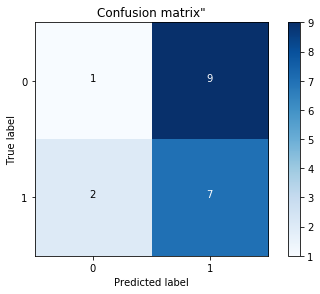

   id                                     word_frequency
0   8  [average:0.14029112933437476, bread:0.25314425...
1  10  [ambiance:0.08868789016131416, audience:0.1147...
2  11  [american:0.17643327539663614, area:0.17643327...
3  12  [asked:0.09645116082024972, assistant:0.139945...
4  15  [bar:0.1798990195412054, bathroom:0.2521207365...
   id  True_Label  Predicted_Label  \
0  35           1                1   
1  11           0                1   
2  52           0                1   
3  49           0                1   
4  59           0                1   

                                      word_frequency  
0  [bar:0.1875507772011991, beer:0.10653900196424...  
1  [american:0.17643327539663614, area:0.17643327...  
2  [applebee:0.31210247416196807, ate:0.263312764...  
3  [food:0.0962042520937473, great:0.839547862208...  
4  [better:0.16996058271600312, chocolate:0.15893...  
   id  True_Label  Predicted_Label  \
0  35           1                1   
1  11           0      

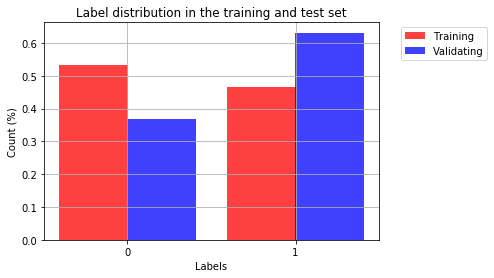

 Build Time: [0.7361665000007633]
Mulitnomial Naive Bayes with CV Predict Time: [0.012066700000104902]


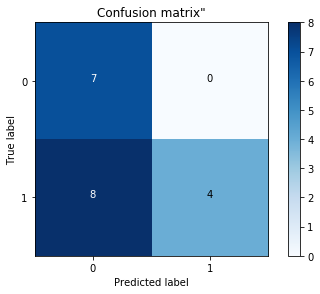

   id                                     word_frequency
0   2  [began:0.1058221974863157, began_order:0.12351...
1   9  [average:0.1218374304877616, average_wait:0.14...
2  10  [ambiance:0.05920337682368828, ambiance_qualit...
3  17  [dishes:0.172036760140751, dishes_ordered:0.28...
4  23  [appetizer:0.11132067929601068, appetizer_wron...
   id  True_Label  Predicted_Label  \
0  28           1                0   
1  83           1                1   
2  47           0                0   
3  10           0                0   
4  54           0                0   

                                      word_frequency  
0  [away:0.15659816415913544, away_immediately:0....  
1  [buddy:0.3998501868657866, buddy_regret:0.3998...  
2  [amazing:0.0925768322162614, amazing_food:0.14...  
3  [ambiance:0.05920337682368828, ambiance_qualit...  
4  [amazing:0.13052674138428863, amazing_dining:0...  
   id  True_Label  Predicted_Label  \
0  28           1                0   
1  83           1      

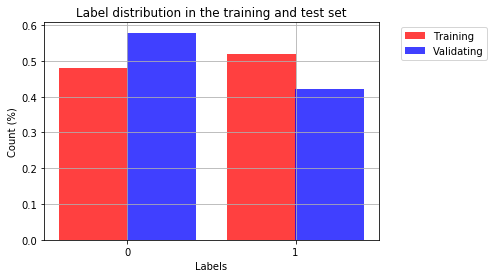

 Build Time: [0.4189678000002459]
Mulitnomial Naive Bayes with CV Predict Time: [0.008878900000127032]


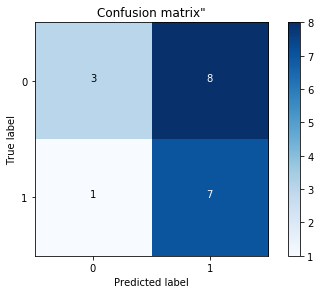

   id                                     word_frequency
0   5  [asked:0.05740928389496295, asked_wait:0.08329...
1  13  [additional:0.09974658760088449, additional_ho...
2  14  [anybody:0.0716502451608417, ate:0.05538480131...
3  19  [calling:0.2273084609792661, calling_police:0....
4  21  [big:0.11469067602387684, big_groups:0.1338637...
   id  True_Label  Predicted_Label  \
0  59           0                1   
1  70           1                1   
2  63           0                1   
3  44           1                1   
4  58           0                1   

                                      word_frequency  
0  [better:0.10114203414575573, better_hibachi:0....  
1  [atmosphere:0.10102641006280562, atmosphere_fo...  
2  [artichoke:0.08263268468293117, artichoke_oliv...  
3  [asked:0.08678206302555483, asked_times:0.1259...  
4  [bucks:0.09427366444876721, bucks_worth:0.0942...  
   id  True_Label  Predicted_Label  \
0  59           0                1   
1  70           1      

In [32]:
# loop over each of the Vecotirization models and run MNB on each
#-----------------LIE--------------------------------#
reportPath_lie = f'{outputDir}/mnb_models_result_report_lie.txt'
lie_feature_vec_files = ['lie_cnt_feature_vector_unigram.txt','lie_cnt_feature_vector_bigram.txt','lie_cnt_feature_vector_trigram.txt',
'lie_tfidf_feature_vector_unigram.txt','lie_tfidf_feature_vector_bigram.txt','lie_tfidf_feature_vector_trigram.txt']

i=0
for m,v in X_train_lie_dfs.items():
    build_test_validate_models(logger,m,v,y_lie,reportPath_lie,f'{outputDir}',lie_feature_vec_files[i])
    i+=1
    #break   

Model Name:             sent_cnt_unigram


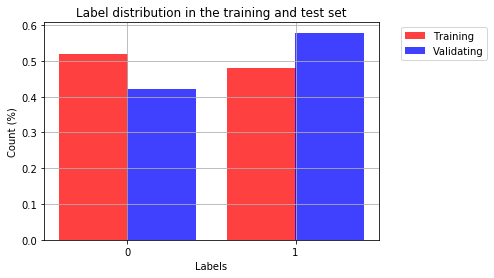

 Build Time: [0.12292340000021795]
Mulitnomial Naive Bayes with CV Predict Time: [0.001436200000171084]


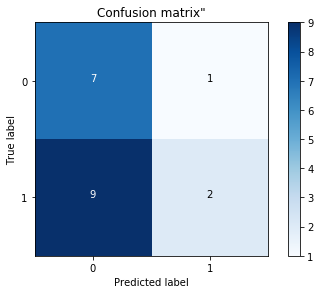

   id                                     word_frequency
0  10  [ambiance:1, audience:1, bread:1, budget:1, ca...
1  14  [anybody:1, ate:1, bad:1, black:1, burger:2, b...
2  20  [actually:1, aghast:1, asked:2, bad:1, came:1,...
3  31  [bad:2, bear:1, discovered:1, dishes:2, enviro...
4  40  [awesome:1, bar:1, bring:1, cicero:1, desserts...
   id  True_Label  Predicted_Label  \
0  20           0                0   
1  53           0                0   
2  43           1                0   
3  88           1                0   
4  61           0                0   

                                      word_frequency  
0  [actually:1, aghast:1, asked:2, bad:1, came:1,...  
1  [asking:1, comfortably:1, decorated:1, dining:...  
2  [amazing:1, atmosphere:1, bit:1, carmelized:1,...  
3  [bowl:1, came:1, cheese:1, crust:1, didnt:1, d...  
4  [amazing:2, ambiance:1, ask:1, authentic:1, be...  
   id  True_Label  Predicted_Label  \
0  20           0                0   
1  53           0      

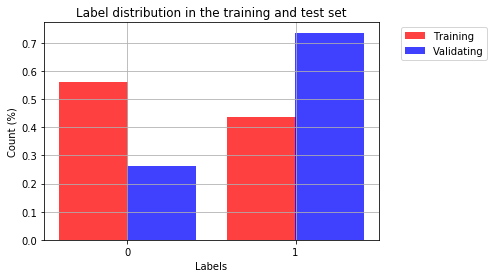

 Build Time: [0.10605889999987994]
Mulitnomial Naive Bayes with CV Predict Time: [0.001564199999847915]


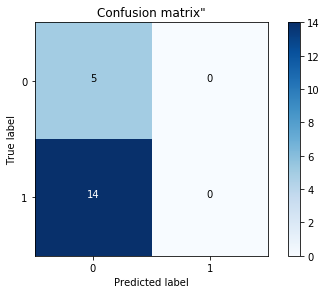

   id                                     word_frequency
0   3  [angry:1, angry_rudely:1, away:1, away_terribl...
1   6  [attitude:1, attitude_waiters:1, bad:1, bad_do...
2  18  [benedict:1, benedict_nacho:1, cheese:1, chees...
3  33  [cold:1, cold_got:1, disappointing:1, disappoi...
4  36  [background:1, background_food:1, baigan:1, ba...
   id  True_Label  Predicted_Label  \
0  70           1                0   
1  38           1                0   
2  88           1                0   
3   6           0                0   
4  89           1                0   

                                      word_frequency  
0  [atmosphere:1, atmosphere_food:1, best:1, best...  
1  [actual:2, actual_food:1, actual_server:1, ado...  
2  [bowl:1, bowl_salad:1, came:1, came_late:1, ch...  
3  [attitude:1, attitude_waiters:1, bad:1, bad_do...  
4  [american:1, american_food:1, ask:1, ask_fathe...  
   id  True_Label  Predicted_Label  \
0  70           1                0   
1  38           1      

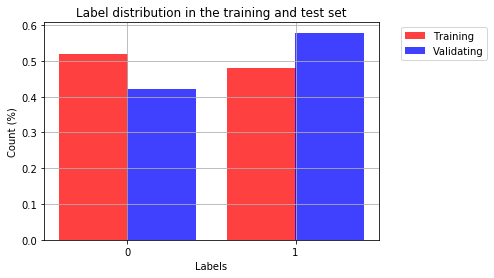

 Build Time: [0.17514979999941716]
Mulitnomial Naive Bayes with CV Predict Time: [0.0013465000001815497]


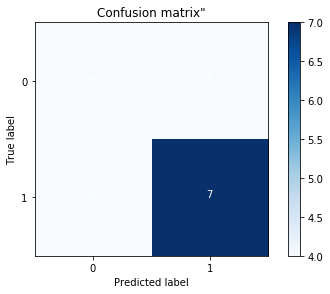

   id                                     word_frequency
0   0  [consider:1, consider_dining:1, dining:1, dish...
1   6  [attitude:1, attitude_waiters:1, attitude_wait...
2   8  [average:1, average_exceptional:1, average_exc...
3  21  [big:1, big_groups:1, big_groups_looking:1, bl...
4  31  [bad:2, bad_flies:1, bad_flies_dishes:1, bad_t...
   id  True_Label  Predicted_Label  \
0  57           0                1   
1  91           1                1   
2  34           1                1   
3  48           0                1   
4  82           1                1   

                                      word_frequency  
0  [ask:1, ask_want:1, ask_want_need:1, bring:1, ...  
1  [attendant:2, attendant_round:1, attendant_rou...  
2  [add:1, add_food:1, add_food_baking:1, baking:...  
3  [absolutely:1, absolutely_world:1, absolutely_...  
4  [ask:1, ask_need:1, big:1, big_piano:1, big_pi...  
   id  True_Label  Predicted_Label  \
0  57           0                1   
1  91           1      

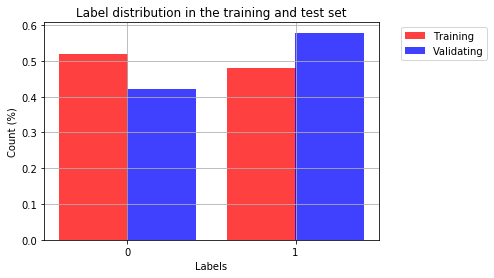

 Build Time: [0.15233990000069753]
Mulitnomial Naive Bayes with CV Predict Time: [0.001207799999974668]


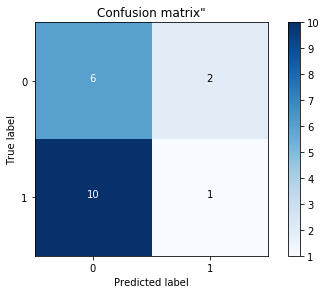

   id                                     word_frequency
0  11  [american:0.1763328761877237, area:0.176332876...
1  26  [awkward:0.19470922264647234, bar:0.1443058943...
2  28  [away:0.24300019121898786, calling:0.256821677...
3  29  [american:0.10732716070143476, area:0.10732716...
4  31  [bad:0.4059184863758213, bear:0.30408891637124...
   id  True_Label  Predicted_Label  \
0  61           0                0   
1  60           0                0   
2  75           1                0   
3  62           0                1   
4  57           0                0   

                                      word_frequency  
0  [amazing:0.16011172912053767, ambiance:0.09826...  
1  [believe:0.13224840819012748, best:0.153345402...  
2  [air:0.15337028683310577, atmosphere:0.1243315...  
3  [accord:0.20137054292201478, amazing:0.1268150...  
4  [ask:0.205850545549861, bring:0.20585054554986...  
   id  True_Label  Predicted_Label  \
0  61           0                0   
1  60           0      

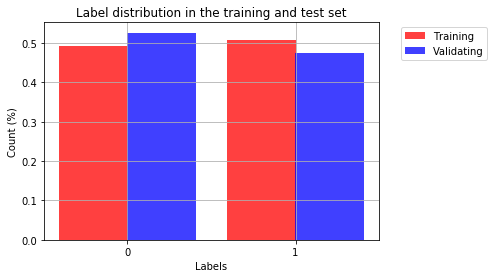

 Build Time: [0.28495100000054663]
Mulitnomial Naive Bayes with CV Predict Time: [0.0019415999995544553]


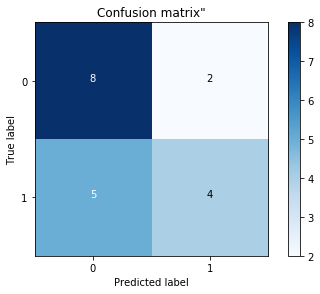

   id                                     word_frequency
0   6  [attitude:0.1520628552547651, attitude_waiters...
1  15  [bar:0.12437861488905702, bar_decor:0.16782172...
2  24  [bit:0.10438898992975763, bit_salty:0.11163178...
3  26  [awkward:0.13561008901269575, awkward_old:0.13...
4  35  [barbque:0.19576358922758855, barbque_decided:...
   id  True_Label  Predicted_Label  \
0  15           0                0   
1  41           1                0   
2  52           0                1   
3  51           0                0   
4  26           1                1   

                                      word_frequency  
0  [bar:0.12437861488905702, bar_decor:0.16782172...  
1  [atmosphere:0.19462249928224967, atmosphere_de...  
2  [applebee:0.18975277114578465, applebee_food:0...  
3  [attended:0.15988467724673366, attended_birthd...  
4  [awkward:0.13561008901269575, awkward_old:0.13...  
   id  True_Label  Predicted_Label  \
0  15           0                0   
1  41           1      

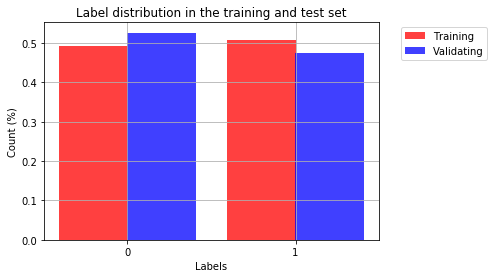

 Build Time: [0.18237069999941014]
Mulitnomial Naive Bayes with CV Predict Time: [0.002271399999699497]


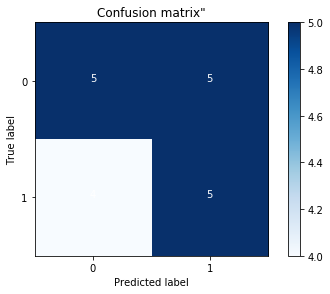

   id                                     word_frequency
0   2  [began:0.0885812496497056, began_order:0.10338...
1   8  [average:0.07937640043257373, average_exceptio...
2  13  [additional:0.09572038124344288, additional_ho...
3  16  [come:0.11827728576065116, come_place:0.159589...
4  18  [benedict:0.10846733008410517, benedict_nacho:...
   id  True_Label  Predicted_Label  \
0  18           0                1   
1  87           1                1   
2  40           1                0   
3  49           0                1   
4  47           0                0   

                                      word_frequency  
0  [benedict:0.10846733008410517, benedict_nacho:...  
1  [amazing:0.13187700533216362, amazing_japanese...  
2  [awesome:0.12757493433300307, awesome_salad:0....  
3  [food:0.05149032030389163, food_great:0.135007...  
4  [amazing:0.07415905308649758, amazing_food:0.1...  
   id  True_Label  Predicted_Label  \
0  18           0                1   
1  87           1      

In [35]:
#-----------------SENTIMENT--------------------------------#
reportPath_sent = f'{outputDir}/mnb_models_result_report_sent.txt'
sent_feature_vec_files = ['sent_cnt_feature_vector_unigram.txt','sent_cnt_feature_vector_bigram.txt','sent_cnt_feature_vector_trigram.txt',
'sent_tfidf_feature_vector_unigram.txt','sent_tfidf_feature_vector_bigram.txt','sent_tfidf_feature_vector_trigram.txt']
    
i=0
for m,v in X_train_sent_dfs.items():
    build_test_validate_models(logger,m,v,y_lie,reportPath_sent,f'{outputDir}',sent_feature_vec_files[i])
    i+=1
    #break

#### --------------------------------------------------------------------------------------------
#### --------------------------------------------------------------------------------------------

**Feature Vector File Names to Read**
* lie_cnt_feature_vector_unigram.txt
* lie_cnt_feature_vector_bigram.txt
* lie_cnt_feature_vector_trigram.txt
* lie_tfidf_feature_vector_unigram.txt
* lie_tfidf_feature_vector_bigram.txt
* lie_tfidf_feature_vector_trigram.txt
* sent_cnt_feature_vector_unigram.txt
* sent_cnt_feature_vector_bigram.txt
* sent_cnt_feature_vector_trigram.txt
* sent_tfidf_feature_vector_unigram.txt
* sent_tfidf_feature_vector_bigram.txt
* sent_tfidf_feature_vector_trigram.txt

#### Model Validation
Perform model validations

### iNterpret
Interpret the model results, make knowledge based recommendations

In [ ]:
# perform interpretation steps

# Report Generation
Execute the below cell to create an HTML report

In [ ]:
# for report auto generation
# testing markup report generation
from nbconvert import HTMLExporter
import codecs
import os
import datetime

stamp = datetime.date.today().strftime("%m-%d-%Y")
exporter = HTMLExporter(template_file='report.tpl')
output, resources = exporter.from_filename(notebook_file_name)
new_fnw = report_file_name
codecs.open(new_fnw, 'w',encoding='utf-8').write(output)